# CS4202 Computer Architecture - Branch Prediction - Report

## Overview

In this report, four branch prediction methods are described, employed, and analysed. The methods include: "always taken", a standard two-bit saturating counter predictor, a "gshare" predictor, and finally a custom _profiling_ predictor.

The submission provided contains a `pin` subdirectory, containing the source code for a PIN tool to create branch traces (this was provided at the beginning, and is unaltered), as well as an `analysis` subdirectory, containing the branch predictor simulator implementations in _Python 3_, as well as a _Jupyter notebook_ which was used to generate this report and all plots .

### Reproducibility & Context

The given analysis and report are created with reproducability in mind. See the following setup section for information about how to reproduce experiments in your environment. The only significant component that could change depending on environment is the PIN branch tracer, as the way instructions are interpreted may change between machines, compiler versions, intel chip versions etc.. The python version may affect the results in some way, but this seems unlikely.

This report and the results provided are done so within the context of the following running environment:

- CPU: `Intel(R) Core(TM) i7-4712HQ CPU @ 2.30GHz`
- PIN version: `pin-3.6-97554-31f0a167d`
- gcc version: `8.2.1 20180831`
- python version: `3.7` (all dependency versions are found in `analysis/requirements.txt`)

## Setup

This section describes how to generate all data used and referenced within the report, as well as how to initialise the interactive jupyter notebook if one wants to run the cells for themselves.

### Python Virtual Environment and Jupyter Notebook

To use the report you're reading in an interactive manner (I would highly recommend doing so as it's more readable with all the figures and code cells), via jupyter notebook, a makefile is provided which will ensure dependencies are present in a virtual environment. Run the following.

```bash
cd analysis
make venv
source venv/bin/activate
jupyter notebook
```

If successful, use the link shown on the terminal to interact with the notebook in an interpreter of your choice (browser, pycharm, etc.).

### PIN Tools & Branch Traces

In order to collect branch traces, we first need to compile the pin tool. Observe in the `pin` directory, there are make files. Simply run `make` within the `pin` directory to compile. The tool should be output to `pin/obj-intel64/`.

The actual data used here is packaged in a compressed zip called `pin/data.zip`, unzip it like so.

```bash
cd pin
unzip data.zip
```

If instead one would like to regenerate all data from the ground up (some of which contains random values) run the following.

```bash
cd pin
make
bash make_echo_traces.sh
bash make_weird_for_traces.sh
```

This (re)compiles the tools and (re)generates the datasets. Two programs are used to generate branch trace files.

#### Programs

The first program is simply `echo` run with various specific sizes of random strings.

The second program is called `weird_for`, the program is quite simple:

```c
#include <stdio.h>

int main() {
  int i = 0;
  int j = 0;
 label:
  for (; i < 100000; i++, j++) {
    printf("%i\n", i);
    if (j % 2 == 0) {
      j++;
      goto label;
    }
  }
  return 0;
}
```

The program outputs a newline separated sequence `0 0 1 1 2 2 3 3 4 4 ...`.

After decompressing the zip file _or_ running the regeneration steps above, one should see the directories `pin/echo_trace` and `pin/weird_for/` containing everything required for the analysis performed in this notebook.

### Miscellaneous

Use the following cell to automatically reload python code upon each execution as necessary.

In [ ]:
%load_ext autoreload
%autoreload 2

## Design & Implementation

This section outlines the design and implementation of the branch predictor simulator, the methods themselves, and design decisions regarding them.

### Branch Predictor Simulator & Methods

Branch predictor methods required by the specification include: always-take, two-bit saturation counter predictor, gshare (with branch tables of size 512, 1024, 2048, and 4096), and finally a profiled approach.

I aim to take a structural approach to branch-prediction here - not interested in simulating a branch-predictor as if it were a piece of computer architecture, but instead simulating the _functionality_ of each predictor in turn, in order to analyse the quality of performance. A prediction is therefore a simple mapping of: predictor state and branch address, to a boolean representing "would this predictor be correct?"

All branch predictor code can be found under `analysis/predictor.py`.

The branch predictor here is modelled as a simple abstract base class in python, which specifies a method `predict_all()`, which transforms the input pandas `DataFrame`, adding a new column "predict_correct". Each new predictor type inherits from the base class and specifies the method to change behaviour.

#### Always Taken

There isn't much to the simulation of this predictor, the value of the "predict_correct" column is always `True`.

#### Two-Bit Saturating Counter

This follows the function of a regular two-bit local predictor. A `SaturatingCounter` type is made which embodies how the branch-table state value works. The counter has a state `taken`, as well as a counter which when the maximum is reached, `taken` flips. If there is a misprediction, the counter is incremented, if the prediction is successful it is decremented. The predictor is implemented as a generalised form first, the counter can saturate up to `n` times. Thus the two-bit predictor is created using the constructor `SaturationPredictor(data=data, n_bits=2)`.

#### GShare

With GShare there are some design decisions that are not specified in the task specification. GShare is functionally the same as regular g-share: we use a saturating counter for each state, and the addressing scheme is an XOR combination of branch address and global branch-taken history. The design decision comes in the number of addressing bits to use. I designed the simulator in such a way that any size of address can be used (as long as it fits in a python integer). Although we could analyse the effect of using various address sizes in terms of performance, all experiments run here use `addr_bits=16` for the sake of constraining the number of dimensions in analysis. It could be an interesting topic in its own right, but here we're only interested in general performance vs other branch-predictor systems.

#### Profile-Based "N-Gram" Branch Predictor

The profile-based approach presented here builds a probabilistic model of taken branches based on a certain number of addresses. Firstly, note the idea of "n-grams" is usually a natural language processing term. E.g. if the sentence `Hello, my name is bob` were converted into conncted bigrams (2-grams), one would get `(Hello my) (my name) (name is) (is bob)`. This is how the stream of branch-taken data is treated: construct n-grams of the address stream using the last `n` branch addresses. The sums of each n-gram in the profile input are added up, and probabilities deduced. Each generated n-gram maps to a probability value. After training, the prediction is randomly generated using the probability value. This means the outcome is not deterministic, but approximating the ideal using the profile data. If an n-gram appears during runtime which was not encountered during the training phase, a default probability value of `0.5` is used.

One important aspect of this design is that addresses are not taken verbatim, they need to be relative to the lowest possible address in the trace. In principle this means that probability values could be continually updated as the "real-world" program runs. However, it would be interesting to see how accurate the predictor can be based on static information at runtime. As such, online-learning is not implemented, but easily could be.

The value of `n` is changeable. E.g. the constructor `NgramProfilerPredictor(data=data, n=10).train(training_data)`  creates a trained predictor, where `data` is the data to predict against, `n` is the size of n-gram to use, and we call `train()` on `training_data` to build up the probability table.

As for how this would be implementable in an architectural sense, it's unclear. The most difficult aspects of this approach to implement in hardware would be: the use of `n` addresses to index into the probability table (maximum `n` will be limited), as well as how exactly the profiling data would be catered for. In order to get profiling data, a user would either have to manually submit to taking traces of their program, or it would have to be done automatically at the compiler stage. I would estimate that gshare approximates this method, and as such we have seen that this method, given smaller amounts of profiling data performs about as well as gshare.

## Analysis

### General Methodoloy

In order to analyse each branch prediction method, several things have to be established.

#### Metrics

Firstly, a metric of performance. In this case _total accuracy_ is sufficient to distinguish methods as "better/worse overall" from each other. Total accuracy here is taken to mean the percentage of branches correctly predicted.

It's also useful to see how accuracy changes as the program runs, as this allows one to recognise the difference between prediction methods for particular types of program patterns. For this I use something I'm calling "instantaneous accuracy" for lack of a better term. This is simply a rolling average of `correct = 1, incorrect = 0` over a particular number of consecutive branches. In other words, it's a smoother approximation of a graph showing large amounts of boolean data.

#### Input Data

Observe the files `pin/make_echo_traces.sh` and `pin/make_weird_for_traces` to see how the data is generated. Generally speaking, for each desired input combination of a program, we collect 5 traces, and also generate some `head` files which take shorter subsections of the beginning of each trace, this is for use in the profiled approach.

### Basic Comparison - Echo

The following cell output shows an overview of the accuracy of the best variants found of each method.

The methods `profiled_16gram_small` and `profiled_16gram_large` represent the n-gram predictor with small, and large profiles to train with, respectively - both use n = 16.

running prediction for always
running prediction for twobit
running prediction for gshare_4096
running prediction for profiled_16gram_small
running prediction for profiled_16gram_large


,name,accuracy
0,always,0.486068
1,twobit,0.867163
2,gshare_4096,0.903195
3,profiled_16gram_small,0.863680
4,profiled_16gram_large,0.961206


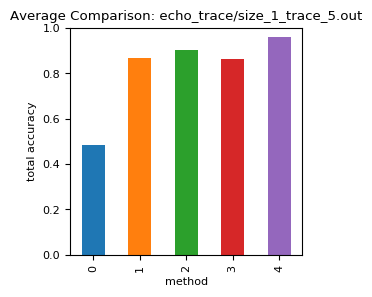

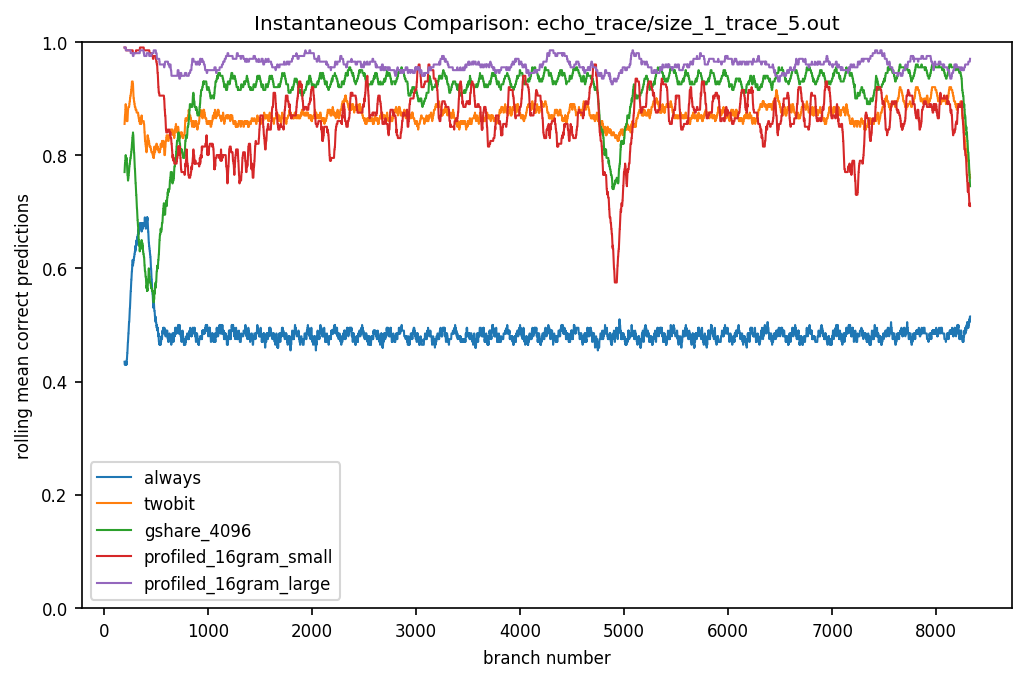

In [107]:
from predictor import import_data, run_plot_compare, AlwaysPredictor, SaturationPredictor, GSharePredictor, NgramProfilerPredictor

data = import_data('../pin/echo_trace/size_1_trace_5.out')
profile_large = import_data('../pin/echo_trace/size_1000_trace_1.out')
profile_small = import_data('../pin/echo_trace/size_1000_head.out')

results, accuracy, fig1, fig2 = run_plot_compare(
    name='echo_trace/size_1_trace_5.out',
    rolling_window=200,
    test_set={
        'always': AlwaysPredictor(data=data, always_taken=True),
        'twobit': SaturationPredictor(data=data, n_bits=2),
        'gshare_4096': GSharePredictor(data=data, n_bits=2, addr_bits=16, table_size=4096),
        'profiled_16gram_small': NgramProfilerPredictor(data=data, n=16).train(profile_small),
        'profiled_16gram_large': NgramProfilerPredictor(data=data, n=16).train(profile_large),
    },
)

accuracy

The profiling n-gram approach (when given access to a large amount of training data) appears to perform best here, followed by gshare with a branch table of size 4096. The always-taken predictor quite expectedly performs at roughly 50%.



running prediction for always
running prediction for twobit
running prediction for gshare_4096
running prediction for profiled_16gram_vsmall
running prediction for profiled_16gram_small
running prediction for profiled_16gram_large


,name,accuracy
0,always,0.486045
1,twobit,0.867313
2,gshare_4096,0.903737
3,profiled_16gram_vsmall,0.515019
4,profiled_16gram_small,0.864593
5,profiled_16gram_large,0.962039


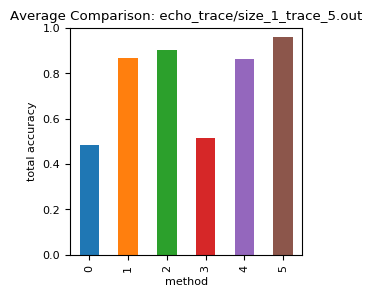

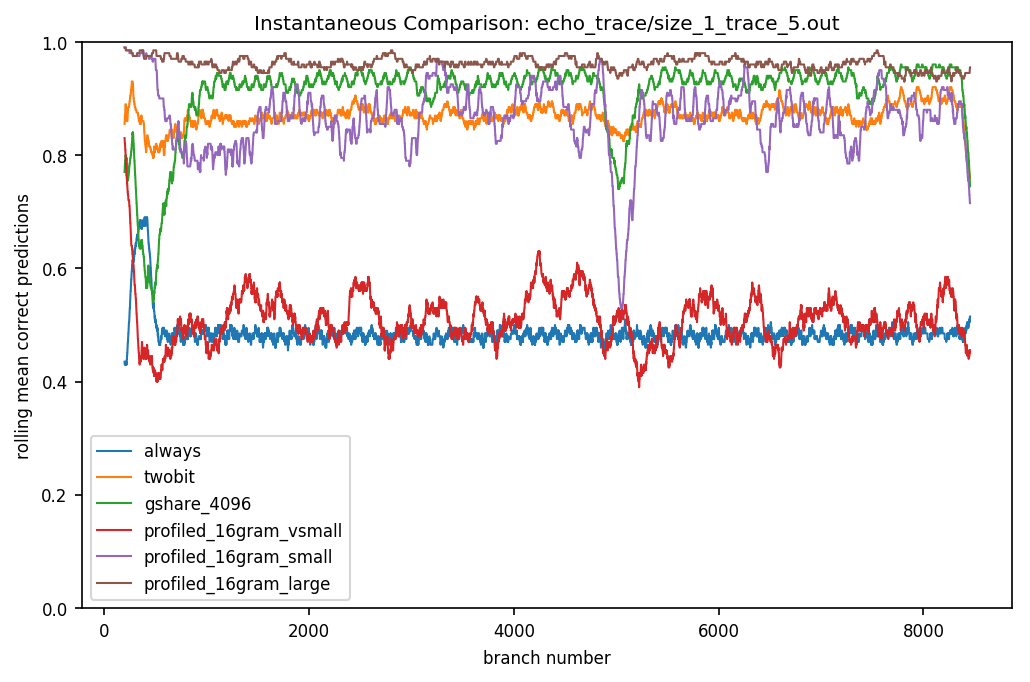

In [108]:
from predictor import import_data, run_plot_compare, AlwaysPredictor, SaturationPredictor, GSharePredictor, NgramProfilerPredictor

data = import_data('../pin/weird_for_trace/trace_5.out')
profile_large = import_data('../pin/weird_for_trace/trace_1.out')
profile_small = import_data('../pin/weird_for_trace/500_head.out')
profile_vsmall = import_data('../pin/weird_for_trace/100_head.out')

results, accuracy, fig1, fig2 = run_plot_compare(
    name='echo_trace/size_1_trace_5.out',
    rolling_window=200,
    test_set={
        'always': AlwaysPredictor(data=data, always_taken=True),
        'twobit': SaturationPredictor(data=data, n_bits=2),
        'gshare_4096': GSharePredictor(data=data, n_bits=2, addr_bits=16, table_size=4096),
        'profiled_16gram_vsmall': NgramProfilerPredictor(data=data, n=16).train(profile_vsmall),
        'profiled_16gram_small': NgramProfilerPredictor(data=data, n=16).train(profile_small),
        'profiled_16gram_large': NgramProfilerPredictor(data=data, n=16).train(profile_large),
    },
)

accuracy

As we can see, the order of performance is very similar for `weird_for`. Also note that when using a very small amount of training data (at least the subsection used in this example), it does not generalise very well, only slightly better than always-taken.

### GShare Analysis

#### GShare - Table Size

The following cell output shows a comparison between gshare methods using varying table sizes.

running prediction for gshare_512
running prediction for gshare_1024
running prediction for gshare_2048
running prediction for gshare_4096


,name,accuracy
0,gshare_512,0.868604
1,gshare_1024,0.870406
2,gshare_2048,0.905837
3,gshare_4096,0.903195


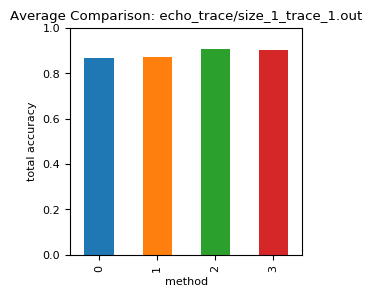

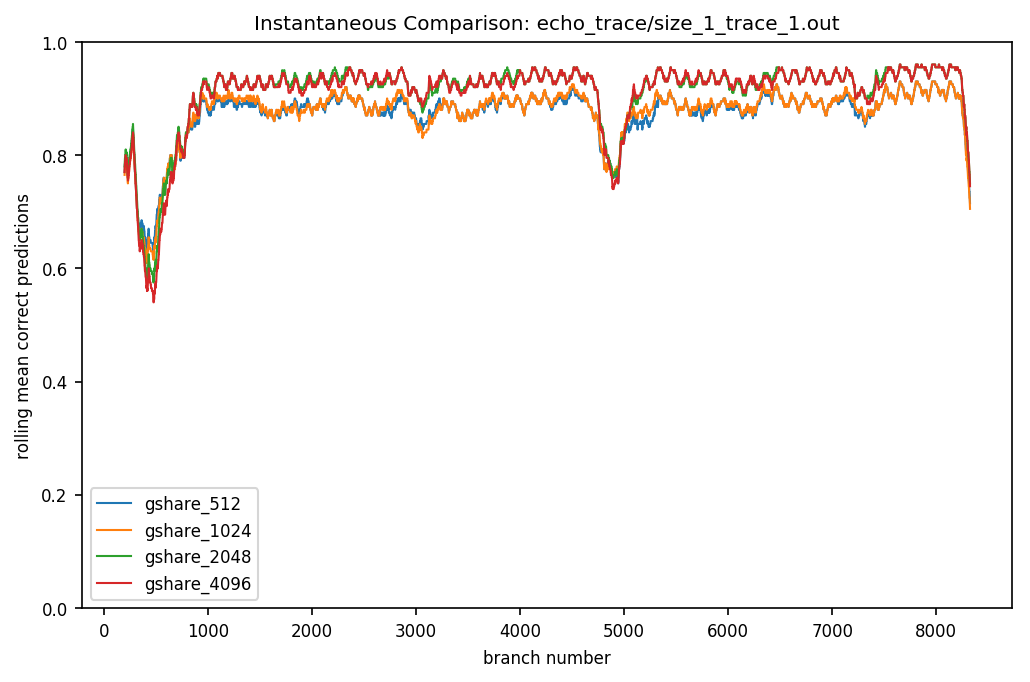

In [109]:
from predictor import import_data, run_plot_compare, GSharePredictor

data = import_data('../pin/echo_trace/size_1_trace_1.out')

results, accuracy, fig1, fig2 = run_plot_compare(
    name='echo_trace/size_1_trace_1.out',
    rolling_window=200,
    test_set={
        'gshare_512': GSharePredictor(data=data, n_bits=2, addr_bits=16, table_size=512),
        'gshare_1024': GSharePredictor(data=data, n_bits=2, addr_bits=16, table_size=1024),
        'gshare_2048': GSharePredictor(data=data, n_bits=2, addr_bits=16, table_size=2048),
        'gshare_4096': GSharePredictor(data=data, n_bits=2, addr_bits=16, table_size=4096),
    },
)

accuracy

These results quite clearly show that a larger branch table size roughly corresponds to higher performance. However, it may be that there are diminishing returns, perhaps even slightly worse performance after a certain table size.

Performance with a table size of 4096 was slightly worse than that with a table size of 2048 - at least for this example. We could speculate as to why this is the case, regarding the algorithm/system itself. However, it may be the case that, for large table sizes, the experimental trace being used is pathological for gshare. In the next section, we analyse `gshare_4096` on traces from multiple program sources.

#### GShare - Program Comparison

Next, we compare `gshare_4096` on traces from both programs.

running prediction for gshare_4096_echo
running prediction for gshare_4096_weird_for


,name,accuracy
0,gshare_4096_echo,0.903195
1,gshare_4096_weird_for,0.903737


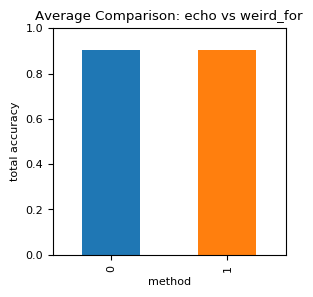

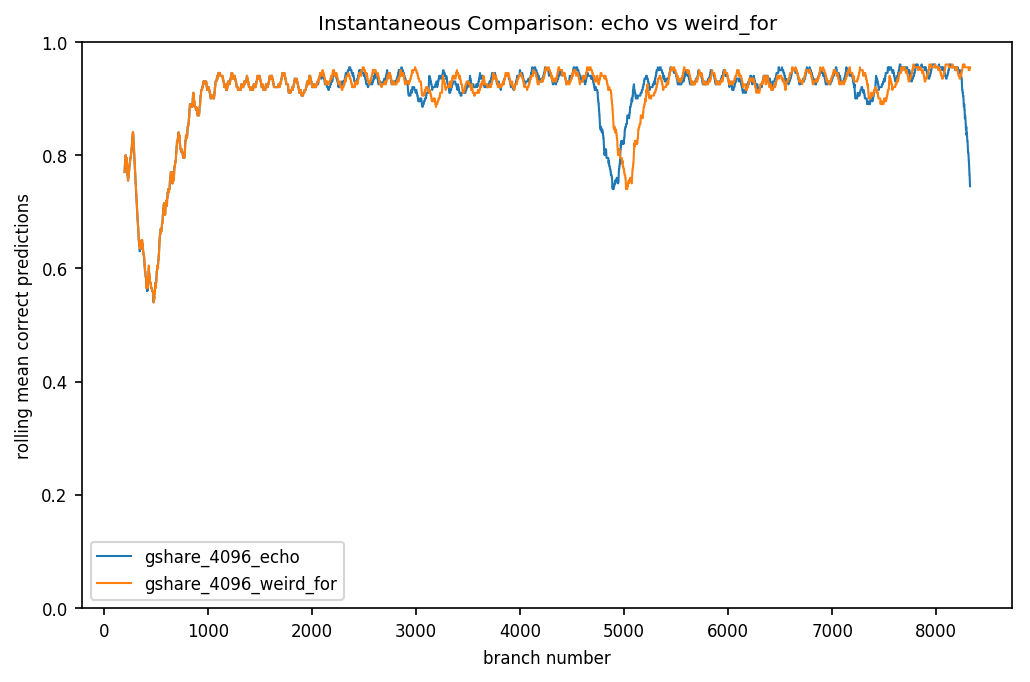

In [110]:
from predictor import import_data, run_plot_compare, GSharePredictor

data1 = import_data('../pin/echo_trace/size_1_trace_1.out')
data2 = import_data('../pin/weird_for_trace/trace_1.out')

results, accuracy, fig1, fig2 = run_plot_compare(
    name='echo vs weird_for',
    rolling_window=200,
    test_set={
        'gshare_4096_echo': GSharePredictor(data=data1, n_bits=2, addr_bits=16, table_size=4096),
        'gshare_4096_weird_for': GSharePredictor(data=data2, n_bits=2, addr_bits=16, table_size=4096),
    },
)

accuracy

We find that gshare performs equally well for both program traces, although performing very marginally better with `weird_for`.

### Ngram Profile Predictor Analysis

#### Ngram Predictor - Ngram Size

One aspect which will impact performance of the probabilistic n-gram method is the size of the n-gram in question. Larger n-grams can accommodate for larger contexts, mapping larger sections of history to a branch probability. However, at the same time, using a larger n-gram means that there may be less statistical confidence for each given n-gram - depending on the program. For instance, with `n = 1`, if the true probability of branching given a (relative) branch address is very high irrespective of the branch history, this will be reflected in the collected n-grams. If `n` is much higher, the unrelated preceding branch history may interfere with that judgement.

The following shows a comparison between n-gram sizes of 1, 2, 8, 16, 32, 64, and 256 respectively. The prediction is run using `echo` traces. To aid confidence that the method is able to generalise somewhat, we train using profiling data from one of the 1000-length echo traces, and test against one of the 1-length echo traces.

running prediction for profiled_1gram
running prediction for profiled_2gram
running prediction for profiled_8gram
running prediction for profiled_16gram
running prediction for profiled_32gram
running prediction for profiled_64gram
running prediction for profiled_256gram


,name,accuracy
0,profiled_1gram,0.880735
1,profiled_2gram,0.884458
2,profiled_8gram,0.892505
3,profiled_16gram,0.963488
4,profiled_32gram,0.978381
5,profiled_64gram,0.983065
6,profiled_256gram,0.998439


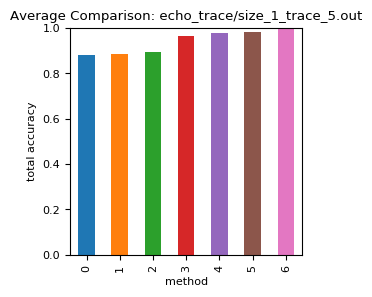

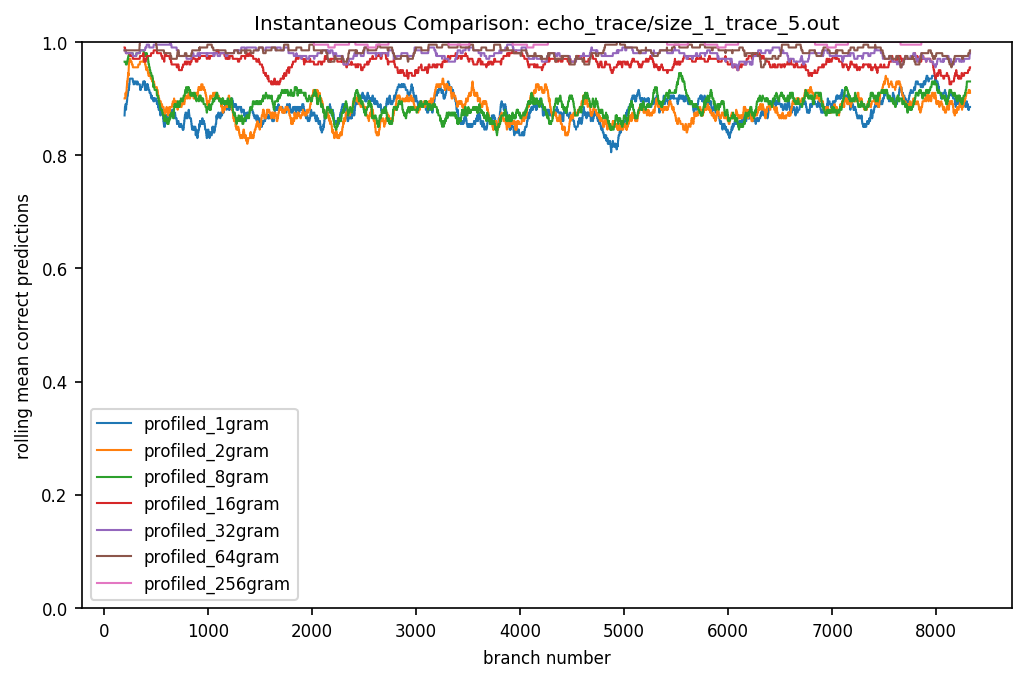

In [111]:
from predictor import import_data, run_all, run_plot_compare, NgramProfilerPredictor

data = import_data('../pin/echo_trace/size_1_trace_5.out')
profile = import_data('../pin/echo_trace/size_1000_trace_1.out')

results, accuracy, fig1, fig2 = run_plot_compare(
    name='echo_trace/size_1_trace_5.out',
    rolling_window=200,
    test_set={
        'profiled_1gram': NgramProfilerPredictor(data=data, n=1).train(profile),
        'profiled_2gram': NgramProfilerPredictor(data=data, n=2).train(profile),
        'profiled_8gram': NgramProfilerPredictor(data=data, n=8).train(profile),
        'profiled_16gram': NgramProfilerPredictor(data=data, n=16).train(profile),
        'profiled_32gram': NgramProfilerPredictor(data=data, n=32).train(profile),
        'profiled_64gram': NgramProfilerPredictor(data=data, n=64).train(profile),
        'profiled_256gram': NgramProfilerPredictor(data=data, n=256).train(profile),
    },
)

accuracy

It appears quite obviously as though n-gram size can indefinitely increase performance. With regards to how a profiled approach works, it makes sense that one would favour large sections of history information over more instantaneous information _if_ the majority of the program does the same work. Larger n-grams with high confidence correspond to less generalised regions in the program. If a program's path of execution is more obfuscatory, more dependant on input, then it may be the case that larger n-grams hinder performance.

Note: although the "best" `NgramProfilerPredictor` is the one with the highest `n` in this case, for the sake of the earlier comparison against other methods `n=16` is used as it seems like a reasonable comprimise between "implementable in realtime hardware" and "best presented system".

The next section works directly off the aforementioned question of potential program entropy, and thus we analyse performance of the n-gram predictor on multiple program traces.

#### Ngram Predictor - Program Comparison (Small N-Gram)

First, we compare the performance training against each program, with lowest the possible n-gram value (1). Afterwards we do the same for a high `n` value, `n = 64`.

running prediction for profiled_16gram_echo
running prediction for profiled_16gram_weird_for


,name,accuracy
0,profiled_16gram_echo,0.877732
1,profiled_16gram_weird_for,0.876537


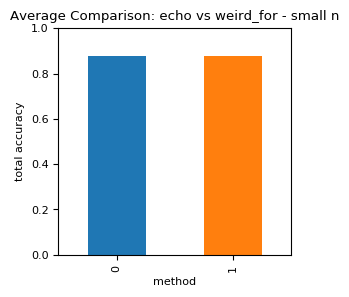

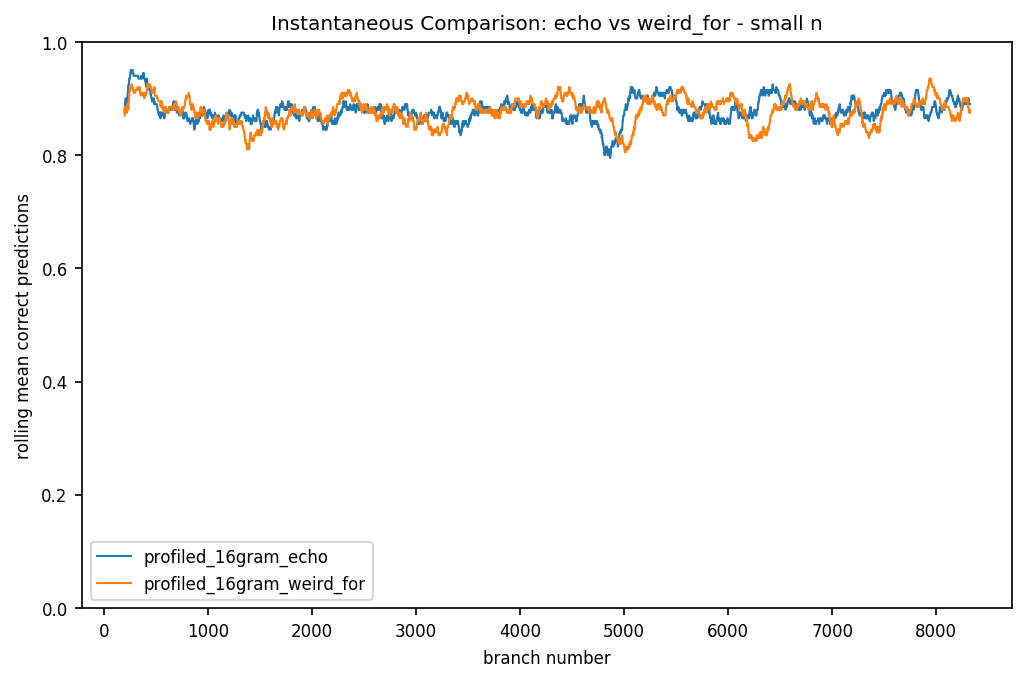

In [112]:
from predictor import import_data, run_all, run_plot_compare, NgramProfilerPredictor

data1 = import_data('../pin/echo_trace/size_1_trace_5.out')
profile1 = import_data('../pin/echo_trace/size_1000_trace_1.out')

data2 = import_data('../pin/weird_for_trace/trace_5.out')
profile2 = import_data('../pin/weird_for_trace/trace_1.out')

results, accuracy, fig1, fig2 = run_plot_compare(
    name='echo vs weird_for - small n',
    rolling_window=200,
    test_set={
        'profiled_16gram_echo': NgramProfilerPredictor(data=data1, n=1).train(profile1),
        'profiled_16gram_weird_for': NgramProfilerPredictor(data=data2, n=1).train(profile2),
    },
)

accuracy

running prediction for profiled_16gram_echo
running prediction for profiled_16gram_weird_for


,name,accuracy
0,profiled_16gram_echo,0.985587
1,profiled_16gram_weird_for,0.985691


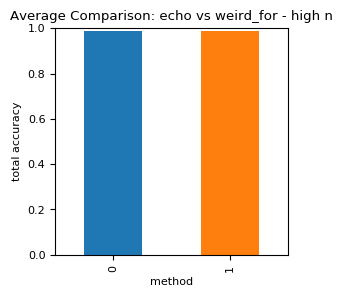

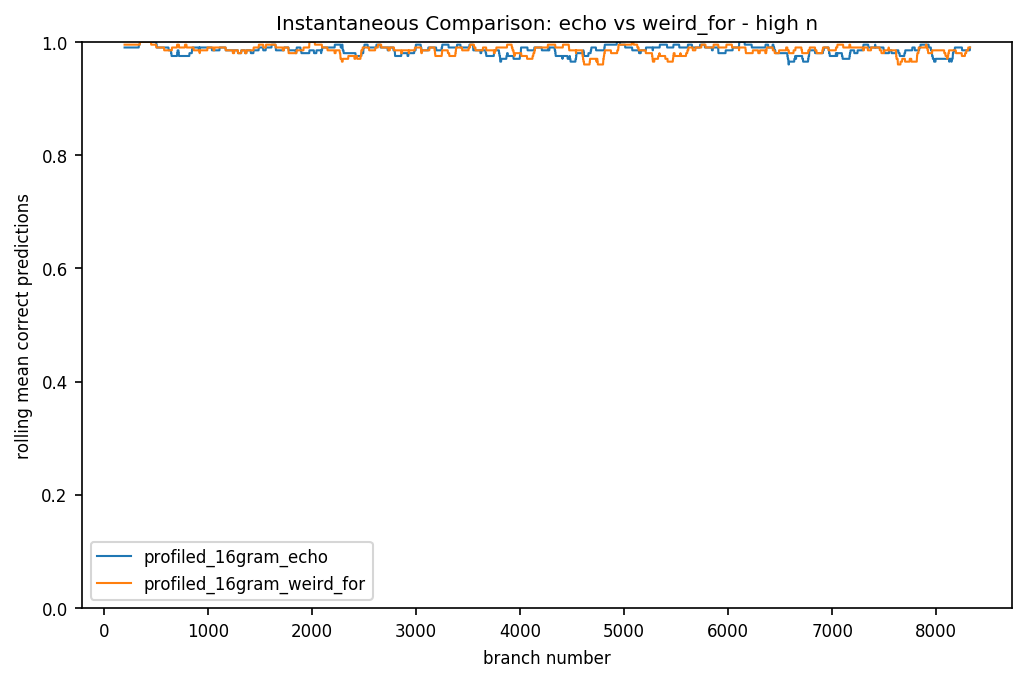

In [113]:
from predictor import import_data, run_all, run_plot_compare, NgramProfilerPredictor

data1 = import_data('../pin/echo_trace/size_1_trace_5.out')
profile1 = import_data('../pin/echo_trace/size_1000_trace_1.out')

data2 = import_data('../pin/weird_for_trace/trace_5.out')
profile2 = import_data('../pin/weird_for_trace/trace_1.out')

results, accuracy, fig1, fig2 = run_plot_compare(
    name='echo vs weird_for - high n',
    rolling_window=200,
    test_set={
        'profiled_16gram_echo': NgramProfilerPredictor(data=data1, n=64).train(profile1),
        'profiled_16gram_weird_for': NgramProfilerPredictor(data=data2, n=64).train(profile2),
    },
)

accuracy

The previous two sets of profiling runs show that - at least as far as these program traces are concerned - n-gram size is not related to the difference in performance. One program, `weird_for` is slightly faster, consistently (albeit by a vanishingly small amount). Program complexity _may_ not scale speed difference, however, more programs of varying complexities would be needed in order to confirm this. Currently this hypothesis is in the air.

#### Ngram Predictor - Profile Size

Next, we analyse the effect of profile size on the accuracy of the n-gram predictor. Previous examples of the n-gram predictor use a large profile (the entirety of a trace) to test with. It would be wise investigate how much data is actually required to generalise the predictor enough, in the interest of maximising efficiency.

First, we use a small subset (take the first 500 lines of a trace file - approximately 6% of the total collected data) and see if it generalises across to other cases as an experiment.

running prediction for profiled_1gram
running prediction for profiled_2gram
running prediction for profiled_8gram
running prediction for profiled_16gram
running prediction for profiled_32gram
running prediction for profiled_64gram


,name,accuracy
0,profiled_1gram,0.865602
1,profiled_2gram,0.868244
2,profiled_8gram,0.847466
3,profiled_16gram,0.865241
4,profiled_32gram,0.782729
5,profiled_64gram,0.653855


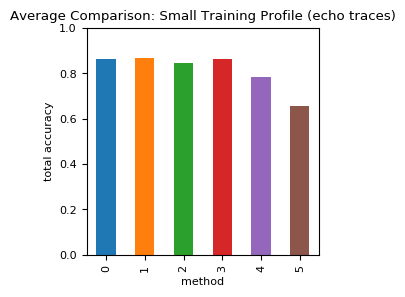

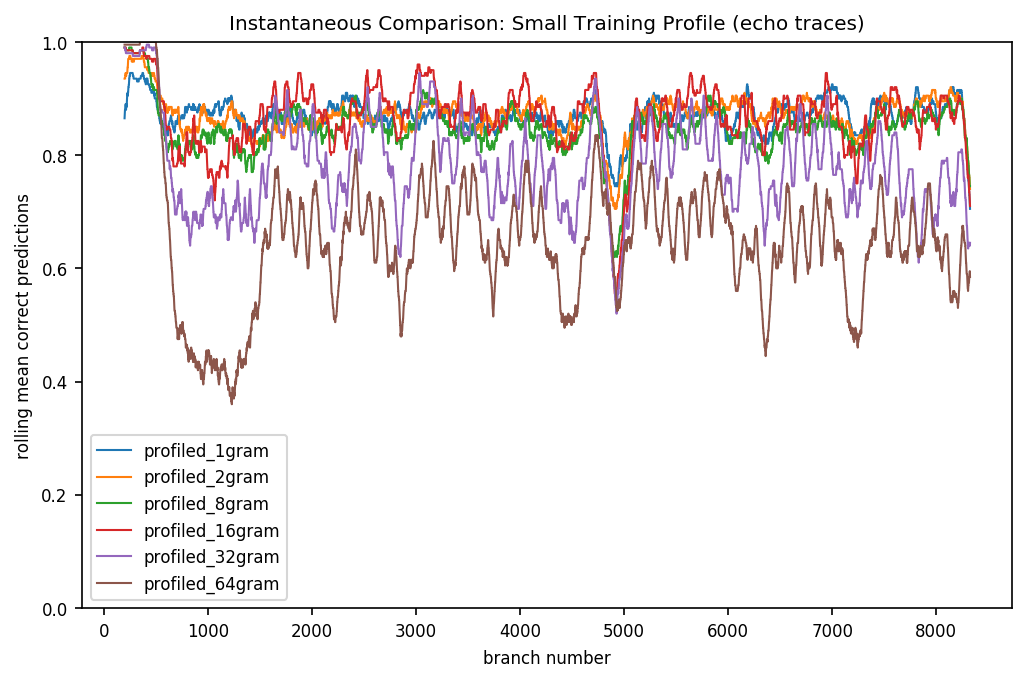

In [114]:
from predictor import import_data, run_plot_compare, NgramProfilerPredictor

# running with minimal training

# test against more complicated program input
data = import_data('../pin/echo_trace/size_1000_trace_5.out')

# train using a subset of the branch traces from the simplest program input
profile1 = import_data('../pin/echo_trace/size_1_head.out')

results, accuracy, fig1, fig2 = run_plot_compare(
    name='Small Training Profile (echo traces)',
    rolling_window=200,
    test_set={
        'profiled_1gram': NgramProfilerPredictor(data=data, n=1).train(profile1),
        'profiled_2gram': NgramProfilerPredictor(data=data, n=2).train(profile1),
        'profiled_8gram': NgramProfilerPredictor(data=data, n=8).train(profile1),
        'profiled_16gram': NgramProfilerPredictor(data=data, n=16).train(profile1),
        'profiled_32gram': NgramProfilerPredictor(data=data, n=32).train(profile1),
        'profiled_64gram': NgramProfilerPredictor(data=data, n=64).train(profile1),
    },
)

accuracy

Overall we see worse performance than when using the full trace file, which would be easy to explain in terms of seeing a smaller profile as a smaller number of "samples".

However, for large n-gram sizes (keeping profile size constant), we see performance degrade, unlike in the example where the full trace is used. This may be explained by the fact that when n is higher, the number of possible n-gram samples is necessarily smaller. Thus less statistical confidence can be gained in any given n-gram. There are more cases in which an n-gram is not found, and the predictor reverts to default probability (50%), which increases mispredicton.

## Evaluation & Conclusion

### Evaluation

In this report, a branch predictor simulator mechanism is provided as well as a pipeline for analysing data from PIN branch traces. The branch predictor simulator can be extended and modified easily. Also presented is a suite of highly reproducable analysis showing main performance differences between each predictor type. A probabilistic n-gram profile-based predictor is employed, and analysed against the other methods. The effects of the n-gram length parameters for the profile-based predictor are also analysed.

Although there are multiple programs being tested here, there should be more. There are plenty of avenues for analysing the effect of program entropy (expected surprise) on each predictor type.

### Conclusion

Although he profiled approach introduced here can clearly outperform the other approaches. It is questionable as to whether or not it is implemantable in hardware. However, the approach can generalise from smaller subsections of traces onto much larger regions, this is promising.

Gshare benefits from larger branch-table sizes.